# Implémentez un modèle de scoring

- **Projet 7 du parcours « Data Scientist » d'OpenClassrooms**
- **Mark Creasey**

## Étape 3 : Préparation du dashboard


## 1.1 Compréhension du problème

### 1.1.1 Problématique

La société financière, nommée **"Prêt à dépenser"**, propose des crédits à la consommation pour des
personnes ayant peu ou pas du tout d'historique de prêt.

L'entreprise souhaite mettre en œuvre **un outil de “scoring crédit”** pour calculer la qu'un client
rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc
développer **un algorithme de classification** en s'appuyant sur des sources de données variées (données
comportementales, données provenant d'autres institutions financières, etc.).

### 1.1.2 Les données

Voici [les données](https://www.kaggle.com/c/home-credit-default-risk/data) pour réaliser le
dashboard. Pour plus de simplicité, vous pouvez les télécharger à
[cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip).

### 1.1.1 Mission

- Sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l'élaboration du modèle de scoring.
- Analyser ce kernel et l'adapter aux besoins de votre mission.

Focalise sur :

1. La construction d'un **modèle de scoring** qui donnera une prédiction sur la probabilité de faillite
   d'un client de façon automatique.
   - élaboration
   - optimisation
   - comprehension (interpretabilité)
2. Construction d'un **dashboard interactif** qui montre avec transparence les décisions d'octroi de
   crédit, à destination des gestionnaires de la relation client permettant d'interpréter les
   prédictions faites par le modèle et d'améliorer la connaissance client des chargés de relation
   client.


## Développement de l'Application Dashboard 

Le tableau de bord pour le chargé d'étude intégrera au minimum les informations client suivantes :

- N° client, crédit accepté ou non, score détaillé sous forme de jauge colorée selon qu'il est en dessous ou au-dessus du seuil : permet de juger s'il est loin du seuil ou non.
- Sa feature importance locale sous forme de graphique, qui permet au chargé d'étude de comprendre quelles sont les données du client qui ont le plus influencé le calcul de son score

Le tableau de bord présentera également d'autres graphiques sur les autres clients :
- Deux graphiques de features sélectionnées dans une liste déroulante, présentant la distribution de la feature selon les classes, ainsi que le positionnement de la valeur du client
- Un graphique d'analyse bi-variée entre les deux features sélectionnées, avec un dégradé de couleur selon le score des clients, et le positionnement du client
- La feature importance globale

## 1.2 Definition de l'environnement

- `local` : Développement local (avec échantillon de 50 Mo de données)
- `colab` : Google Colab
- `kaggle` : Kaggle Kernel


In [1]:
ENV = 'local'

# if ENV == 'local':
# local development
DATA_FOLDER = '../data/raw'
OUT_FOLDER = '../data/out'
IMAGE_FOLDER = '../images/dashboard'
MODEL_FOLDER = '../saved_models'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC7'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC7'
    MODEL_FOLDER = '/content/drive/MyDrive/data/OC7/saved_models'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC7/dashboard'


## 1.3 Fichiers de données

1. Les données en format CSV (>700Mb compactés) sont à télecharger de ce lien:

- https://www.kaggle.com/c/home-credit-default-risk/data
- Pour plus de simplicité, vous pouvez les télécharger à [cette adresse.](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

2.  Placer le fichier compacté (**.zip**) dans le **DATA_FOLDER** défini ci-dessous


### Noms des fichiers de données (identique pour nettoyage et l'analyse exploratoire)

- Le grand fichier zip des données doit être placé dans `DATA_FOLDER` au préalable
- Tous les autres fichiers de données sont téléchargés ou crées pendant le nettoyage, puis enregistrés dans `OUT_FOLDER`


In [2]:
# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME = 'cleaned_data_scoring.csv' #300000 registres
CLEAN_DATA_SAMPLE = 'cleaned_data_sample.csv'  # 10,000 registres
CLEAN_DATA_FEATURES = 'cleaned_data_features.csv'  # 100 meilleur features
SAMPLE_SIZE = 10000


## 1.4 Requirements: Bibliothèques utilisées dans ce notebook

Ce notebook marche a été testé en developpement local, sur Google Colab et Kaggle

```txt
# copy dans un fichier requirements.txt, puis
# !pip install -r requirements.txt
```


In [3]:
# Decommentarise la ligne suivant si vous ne voulez pas changer vos versions existants
# !pip install numpy pandas matplotlib seaborn scipy sklearn missingno requests


In [4]:
# import local functions
import outils_io
outils_io.install_libraries({'numpy', 'pandas', 'matplotlib',
                             'seaborn', 'scikit-learn', 'imbalanced-learn',
                              'lightgbm', 'shap', 'streamlit'})


required modules: ['matplotlib', 'imbalanced-learn', 'shap', 'streamlit', 'numpy', 'scikit-learn', 'pandas', 'lightgbm', 'seaborn']
missing modules: []


## 1.5 Import dependencies


### 1.5.1 Import des bibliothèques utilisées par ce notebook


In [5]:

from contextlib import contextmanager
import time
import gc
import os
import warnings
import platform
# suppress future warnings de pandas 1.3.0
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn


### 1.5.2 Liste des versions des bibliothèques utilisées


In [7]:
print(f'python version = {platform.python_version()}')
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


python version = 3.7.13
versions des bibliothèques utilisées:
platform==1.0.8; sklearn==1.0.2; seaborn==0.11.2; pandas==1.3.5; numpy==1.21.6; imblearn==0.9.0


### 1.5.3 Configuration défauts d'affichage


In [8]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 20 lignes
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab10")

RANDOM_SEED = 42


### 1.5.4 Bibliothèque personelle

On utilise un nom non standard


In [9]:
import outils_io
import outils_preprocess
import outils_stats
import outils_timed
import outils_vis

# frequently used functions
from outils_vis import to_png
from outils_timed import timer


### 1.5.5 Configuration personelle


In [10]:

# Enregistre parametres globals dans outils
outils_vis.set_option('IMAGE_FOLDER', IMAGE_FOLDER)
outils_vis.set_option('SAVE_IMAGES', True)

if ENV != 'kaggle':
    outils_io.os_make_dir(DATA_FOLDER)
    outils_io.os_make_dir(OUT_FOLDER)

outils_io.os_make_dir(IMAGE_FOLDER)


# 2. Importation des données 




D'autres graphiques complémentaires, par exemple :

Il est attendu de réaliser au moins 2 applications :
- Une API qui au minimum renvoie le score d'un client (moteur d'inférence qui réalise le predict à partir du modèle final sauvegardé)
- Une application Dashboard qui visualise les informations du client et les graphiques associés, et qui appelle l'API via une url pour récupérer le score du client
- Ces applications seront gérées avec un logiciel de gestion de version comme Git (faire des commit), et l'ensemble du code déposé sur Github via push à partir de Git
- Les applications (Dashboard et l'API) seront hébergées sur un serveur cloud, idéalement sur un serveur gratuit PythonAnywhere, Heroku, Streamlit, qui doit rester accessible jusqu'au jury de fin de parcours

### Gauge
- <http://nicolasfauchereau.github.io/climatecode/posts/drawing-a-gauge-with-matplotlib/>

In [11]:
import os, sys
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points


def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation


In [12]:
def gauge(arrow=0.5, labels=['LOW','MEDIUM','HIGH','EXTREME'], 
          title='',min_val=0.,max_val=1.,threshold=-1.0,
          colors='RdYlGn_r', n_colors=-1, ax=None,figsize=(3,2)): 
    
    N=len(labels)
    n_colors = n_colors if n_colors > 0 else N
    if isinstance(colors, str):
        #  matplotlib colormap
        cmap = cm.get_cmap(colors, n_colors)
        cmap = cmap(np.arange(n_colors))
        # colors = cmap[::-1,:].tolist()
        colors = cmap
    if isinstance(colors, list): 
        n_colors= len(colors)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ang_range, _ = degree_range(n_colors)
    
    # plots the sectors and the arcs
    for ang, c in zip(ang_range, colors): 
        ax.add_patch(Wedge((0.,0.), .4, *ang, width=0.10, facecolor='w', lw=2, alpha=0.5))
        ax.add_patch(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=0, alpha=0.8))

    
    # labels (e.g. 'LOW','MEDIUM',...)
    _, mid_points = degree_range(N)
    labels = labels[::-1]
    a=0.45
    for mid, lab in zip(mid_points, labels): 
        ax.text(a * np.cos(np.radians(mid)), a * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=12, \
            fontweight='bold', rotation = rot_text(mid))


    # bottom banner and title
    ax.add_patch(Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2))    
    ax.text(0, -0.10, title, horizontalalignment='center', verticalalignment='center', fontsize=20, fontweight='bold')
    
    # threshold
    if threshold>min_val and threshold<max_val:
        pos=180 * (max_val-threshold)/(max_val-min_val)
        a=0.25; b=0.18; x=np.cos(np.radians(pos)); y= np.sin(np.radians(pos))
        ax.arrow(a*x, a*y,b*x,b*y, width=0.01, head_width=0.0, head_length=0, ls='--',fc='r', ec='r')

    # arrow
    pos=180 * (max_val-arrow)/(max_val-min_val)
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    #ax.add_patch(Circle((0, 0), radius=0.01, facecolor='b', zorder=11))
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    return ax


<AxesSubplot:>

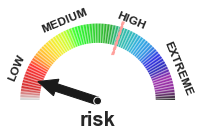

In [13]:
gauge(colors= 'nipy_spectral', n_colors=80,
      arrow=0.1, title='risk', threshold=0.6) 